In [16]:
import pandas as pd
from plotnine import (
    ggplot,
    aes,
    geom_histogram,
    theme_bw,
    labs,
    geom_point,
    scale_color_brewer,
    facet_wrap,
    geom_smooth,
    theme,
    scale_y_log10,
    facet_grid,
)
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
from ydata_profiling import ProfileReport
pd.options.mode.chained_assignment = None
pd.set_option("display.float_format", lambda x: "%.2f" % x)
plt.style.use('ggplot')

In [2]:
df = pd.read_csv("../data/full_data.csv", index_col="SEQN")

# raw data cleaning steps; handle missing
df["KIQ026"] = 0 or df["KIQ026"] == 1


def max_val_null(x, max_val):
    return np.where(x >= max_val, np.nan, x)


df["ALQ130"] = max_val_null(df["ALQ130"], 16)
df["PAD660"] = max_val_null(df["PAD660"], 7777)
df["PAD675"] = max_val_null(df["PAD675"], 7777)
df["PAD680"] = max_val_null(df["PAD680"], 7777)
df["PAQ605"] = df["PAQ605"] == 1
df["PAQ620"] = df["PAQ620"] == 1
df["OCQ180"] = max_val_null(df["OCQ180"], 7777)

In [3]:
column_map = {
    "INDFMMPI": "poverty_num",
    "INDFMMPC": "poverty_cat",
    "PAQ605": "activity_vig_work",
    "PAQ620": "activity_mod_work",
    "PAQ635": "activity_walk_or_use_bike",
    "PAD645": "activity_minutes_walk_bike",
    "PAD660": "activity_vig_min",
    "PAD675": "activity_mod_min",
    "PAD680": "activity_sed_min",
    "DSQTCAFF": "caffeine_sup_mg",
    "DR1ICAFF": "caffeine_intake1_mg",
    "DR2ICAFF": "caffeine_intake2_mg",
    "DR1TCAFF": "caffeine_nutrient1_mg",
    "DR2TCAFF": "caffeine_nutrient2_mg",
    "BMXBMI": "bmi_total",
    "BMXWAIST": "bmi_waist",
    "ALQ130": "alcohol_nmbr_drinks",
    "OCQ180": "occ_hours_worked",
    "OCQ670": "occ_work_shift",
    "DIQ010": "diabetes_diag",
    "DIQ050": "diabetes_insulin",
    "DIQ280": "diabetes_aic",
    "SMQ020": "smoking_100cigs",
    "SMD650": "smoking_cigs_pd",
    "KIQ026": "kidney_had_stones",
    "KIQ029": "kidney_passed_stone",
    "KIQ022": "kidney_weak_failing",
    "RIAGENDR": "demo_gender",
    "RIDRETH3": "demo_race",
    "RIDAGEYR": "demo_age",
}


# Data Cleaning Steps
df = df.rename(column_map, axis=1)
df.head()

poverty_num  poverty_cat  ...  demo_age  caffeine_nutrient2_mg
SEQN                              ...                                 
109263         3.26         3.00  ...      2.00                   3.00
109264         1.29         1.00  ...     13.00                   0.00
109265         2.04         3.00  ...      2.00                   2.00
109266         5.00         3.00  ...     29.00                  38.00
109267         5.00         3.00  ...     21.00                    NaN

[5 rows x 30 columns]

In [4]:
df[
    [
        "caffeine_sup_mg",
        "caffeine_intake1_mg",
        "caffeine_intake2_mg",
        "caffeine_nutrient1_mg",
        "caffeine_nutrient2_mg",
    ]
].round(2).describe()

caffeine_sup_mg  ...  caffeine_nutrient2_mg
count            32.00  ...               10627.00
mean            156.00  ...                  83.95
std             220.69  ...                 150.42
min               2.00  ...                   0.00
25%              52.25  ...                   0.00
50%              98.50  ...                  21.00
75%             169.75  ...                 120.00
max            1200.00  ...                5040.00

[8 rows x 5 columns]

In [5]:
df["any_caffeine"] = df[
    [
        "caffeine_sup_mg",
        "caffeine_intake1_mg",
        "caffeine_intake2_mg",
        "caffeine_nutrient1_mg",
        "caffeine_nutrient2_mg",
    ]
].max(axis=1)
df["any_caffeine_log"] = np.log1p(df["any_caffeine"])
df["any_caffeine"].describe().apply("{0:.0f}".format)

count    12414
mean       115
std        191
min          0
25%          3
50%         50
75%        161
max       5040
Name: any_caffeine, dtype: object

In [6]:
(df.isna().sum() / df.shape[0]).sort_values(ascending=False)

caffeine_intake1_mg          1.00
caffeine_intake2_mg          1.00
caffeine_sup_mg              1.00
kidney_passed_stone          0.94
diabetes_aic                 0.92
diabetes_insulin             0.91
smoking_cigs_pd              0.89
activity_minutes_walk_bike   0.86
activity_vig_min             0.84
activity_mod_min             0.75
occ_hours_worked             0.66
occ_work_shift               0.64
alcohol_nmbr_drinks          0.62
kidney_weak_failing          0.41
activity_sed_min             0.38
activity_walk_or_use_bike    0.38
smoking_100cigs              0.38
caffeine_nutrient2_mg        0.32
poverty_num                  0.21
caffeine_nutrient1_mg        0.20
any_caffeine                 0.20
any_caffeine_log             0.20
bmi_waist                    0.19
bmi_total                    0.16
poverty_cat                  0.08
diabetes_diag                0.04
kidney_had_stones            0.00
activity_mod_work            0.00
demo_gender                  0.00
demo_race     

/Users/rachelhimmel/.pyenv/versions/3.9.12/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 3146 rows containing non-finite values.


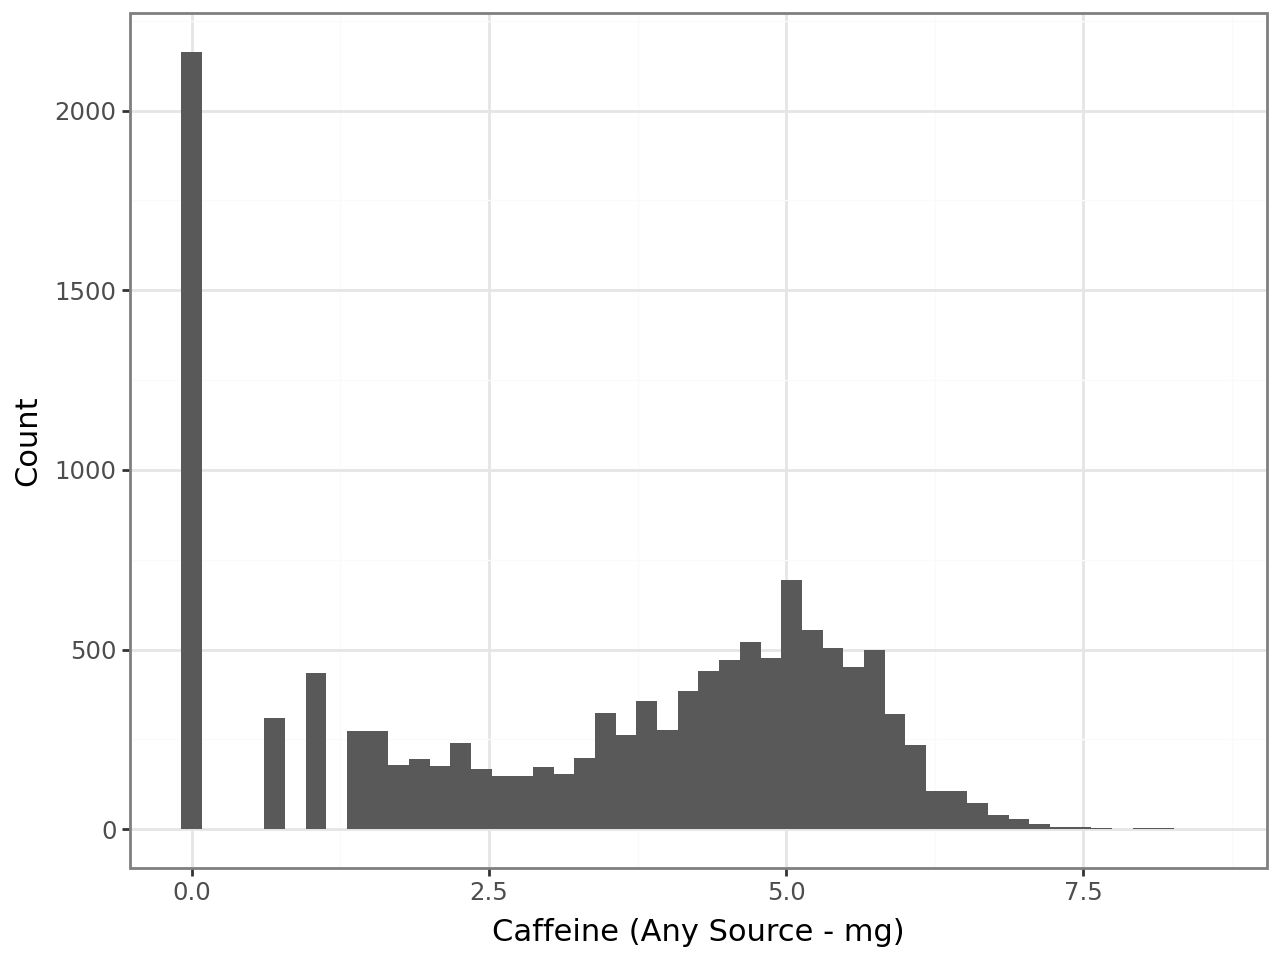

In [7]:
(
    ggplot(data=df, mapping=aes(x="any_caffeine_log"))
    + geom_histogram(bins=50)
    + theme_bw()
    + labs(y="Count", x="Caffeine (Any Source - mg)")
)

/var/folders/rp/1r9gmpk10h51rwrn1c9_502m0000gn/T/ipykernel_73913/606647264.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/rachelhimmel/.pyenv/versions/3.9.12/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1303 rows containing missing values.


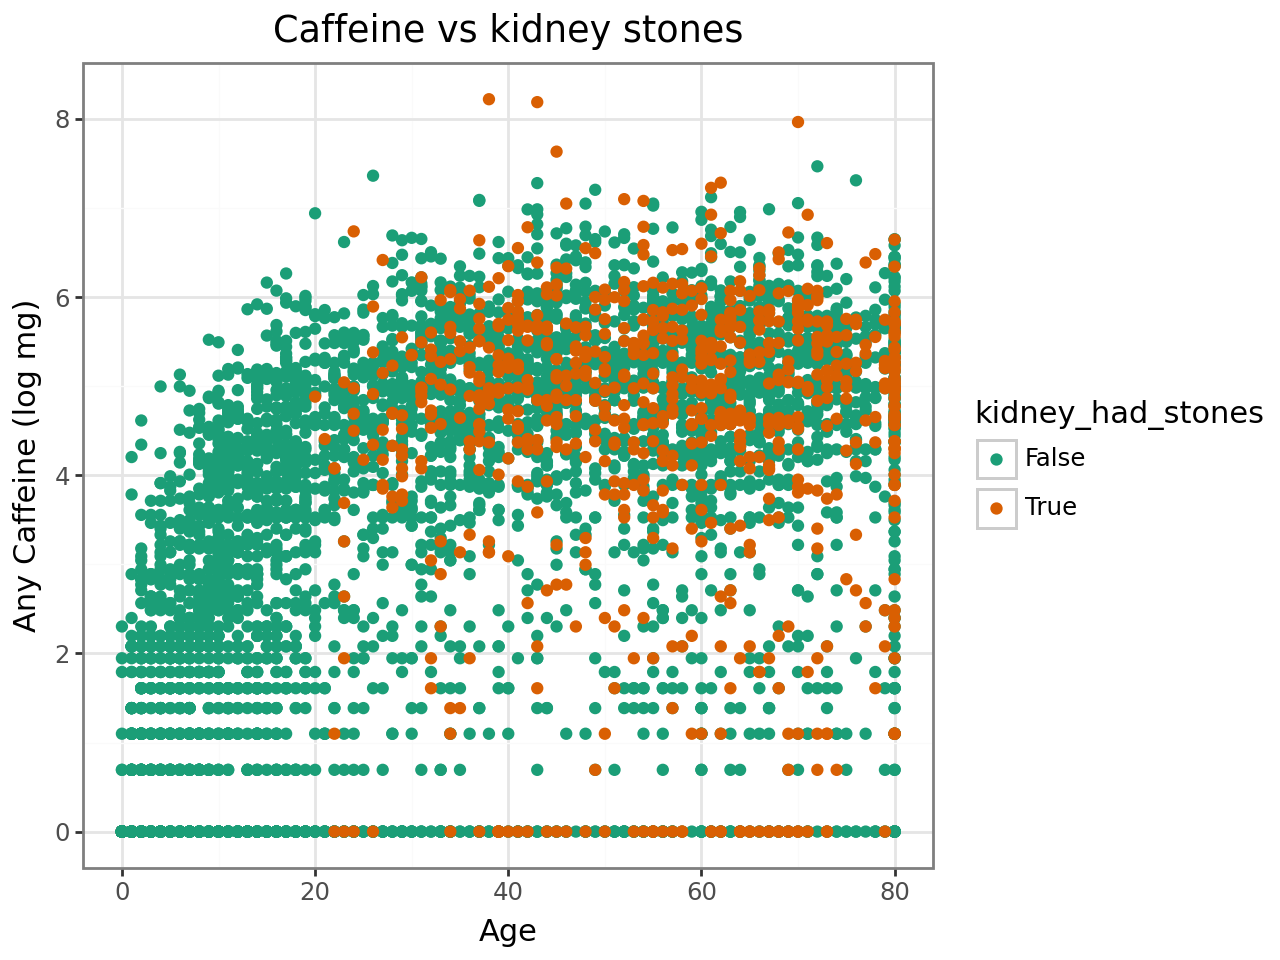

In [8]:
kidney_undersample = (
    df.groupby("kidney_had_stones")
    .apply(lambda x: x.sample(n=min(5500, len(x))))
    .droplevel(0)
)
(
    ggplot(
        data=kidney_undersample,
        mapping=aes(x="demo_age", y="any_caffeine_log", color="kidney_had_stones"),
    )
    + geom_point()
    + theme_bw()
    + labs(y="Any Caffeine (log mg)", x="Age", title="Caffeine vs kidney stones")
    + scale_color_brewer(palette="Dark2", type="qual")
)

/Users/rachelhimmel/.pyenv/versions/3.9.12/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 59474 rows containing non-finite values.


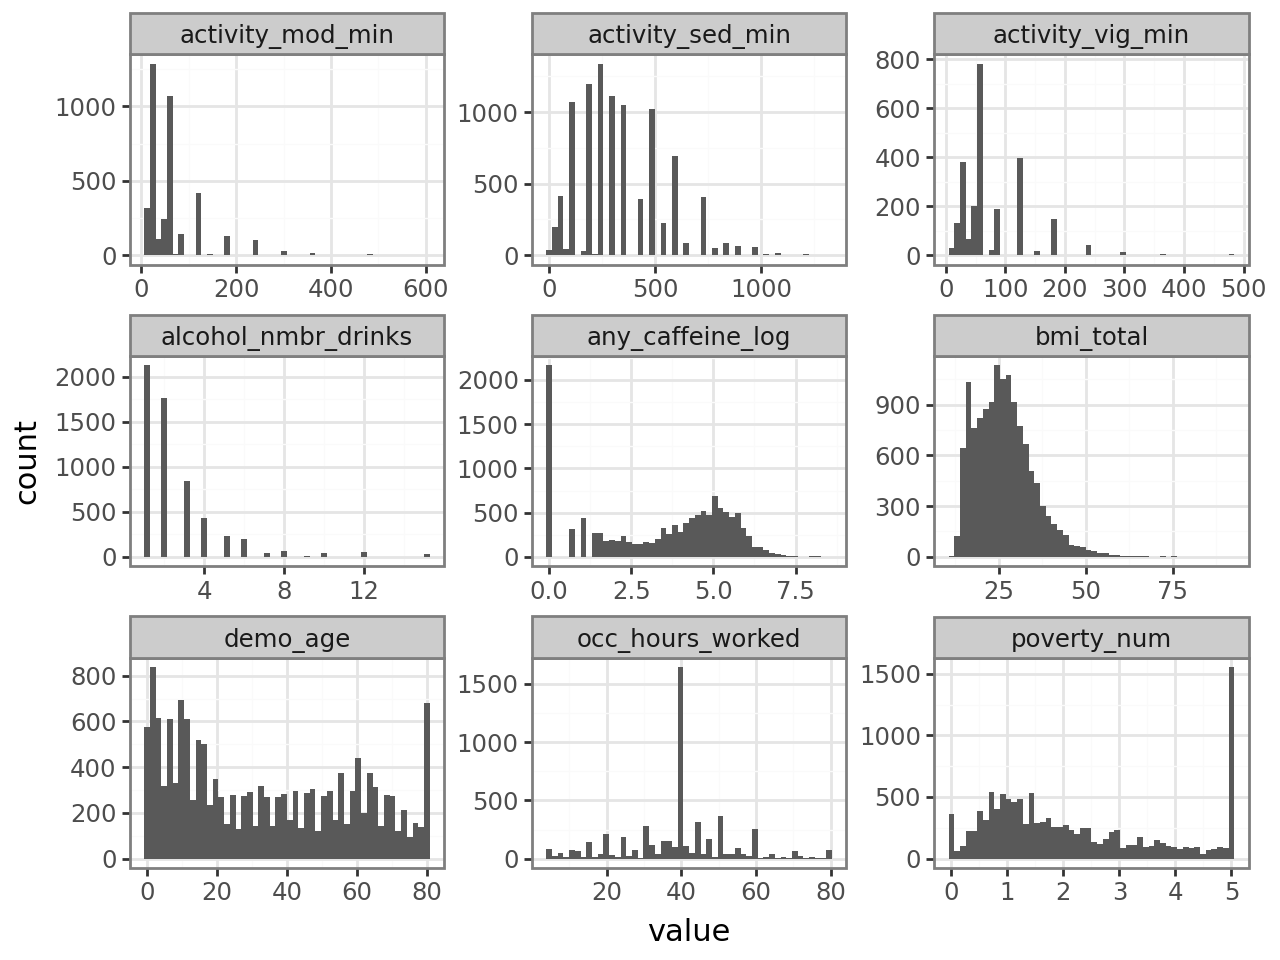

In [9]:
hist_vars = [
    "poverty_num",
    "activity_vig_min",
    "activity_mod_min",
    "activity_sed_min",
    "any_caffeine_log",
    "demo_age",
    "bmi_total",
    "occ_hours_worked",
    "alcohol_nmbr_drinks",
]
(
    ggplot(data=df[hist_vars].melt(), mapping=aes(x="value"))
    + facet_wrap("~variable", scales="free")
    + geom_histogram(bins=50)
    + theme_bw()
)

/Users/rachelhimmel/.pyenv/versions/3.9.12/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 59474 rows containing non-finite values.


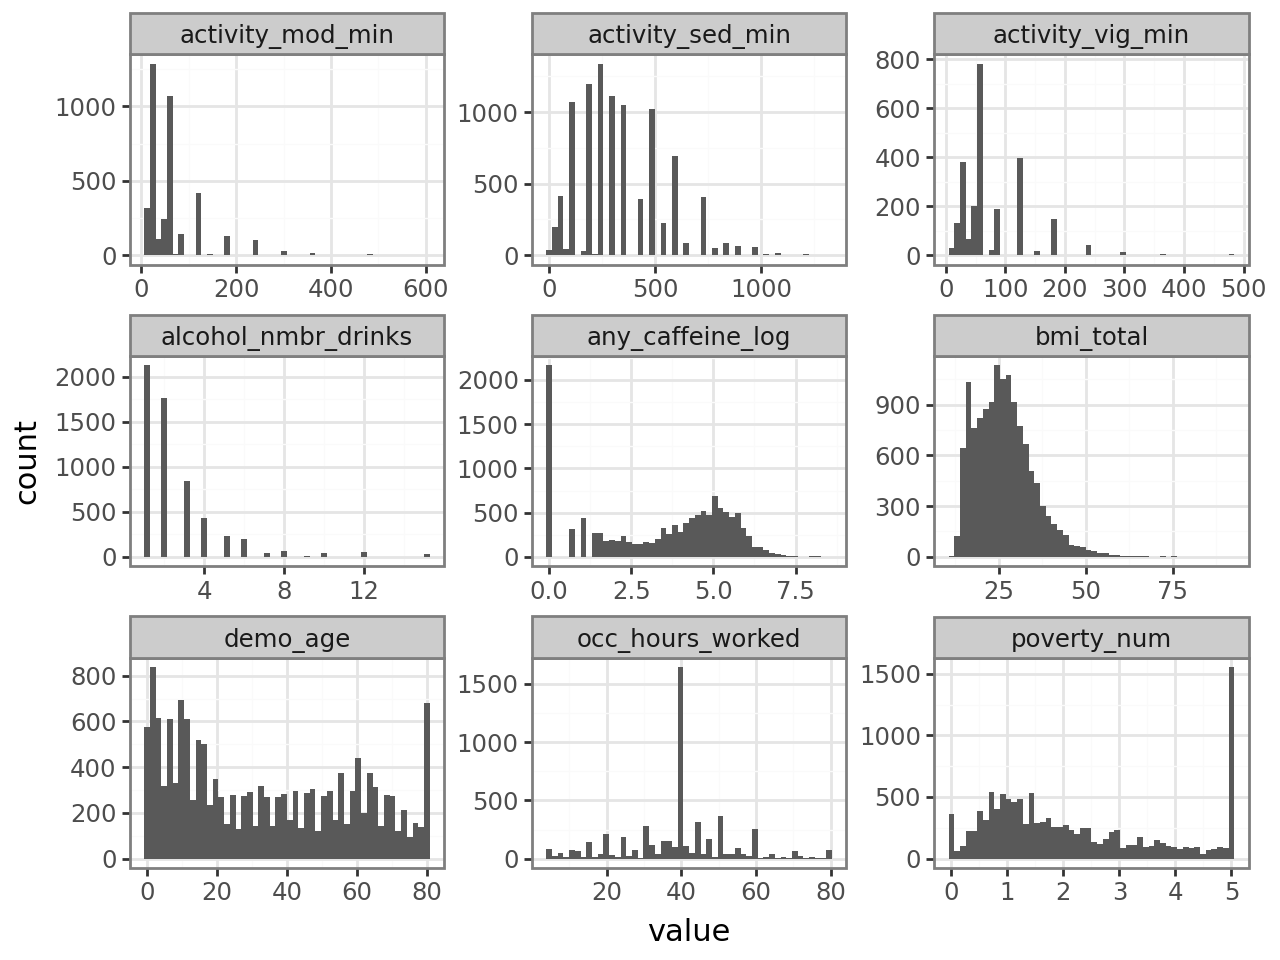

In [10]:
hist_vars = [
    "poverty_num",
    "activity_vig_min",
    "activity_mod_min",
    "activity_sed_min",
    "any_caffeine_log",
    "demo_age",
    "bmi_total",
    "occ_hours_worked",
    "alcohol_nmbr_drinks",
]
(
    ggplot(data=df[hist_vars].melt(), mapping=aes(x="value"))
    + facet_wrap("~variable", scales="free")
    + geom_histogram(bins=50)
    + theme_bw()
)

In [11]:
all_vars = hist_vars + ["any_caffeine_log", "demo_race", "demo_gender"]
df[all_vars].isna().sum() / df.shape[0]

poverty_num           0.21
activity_vig_min      0.84
activity_mod_min      0.75
activity_sed_min      0.38
any_caffeine_log      0.20
demo_age              0.00
bmi_total             0.16
occ_hours_worked      0.66
alcohol_nmbr_drinks   0.62
any_caffeine_log      0.20
demo_race             0.00
demo_gender           0.00
dtype: float64

In [12]:
df[["activity_vig_any", "activity_mod_any", "activity_sed_any"]] = (
    df[["activity_vig_min", "activity_mod_min", "activity_sed_min"]].fillna(0) > 0
)

/Users/rachelhimmel/.pyenv/versions/3.9.12/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 64825 rows containing missing values.


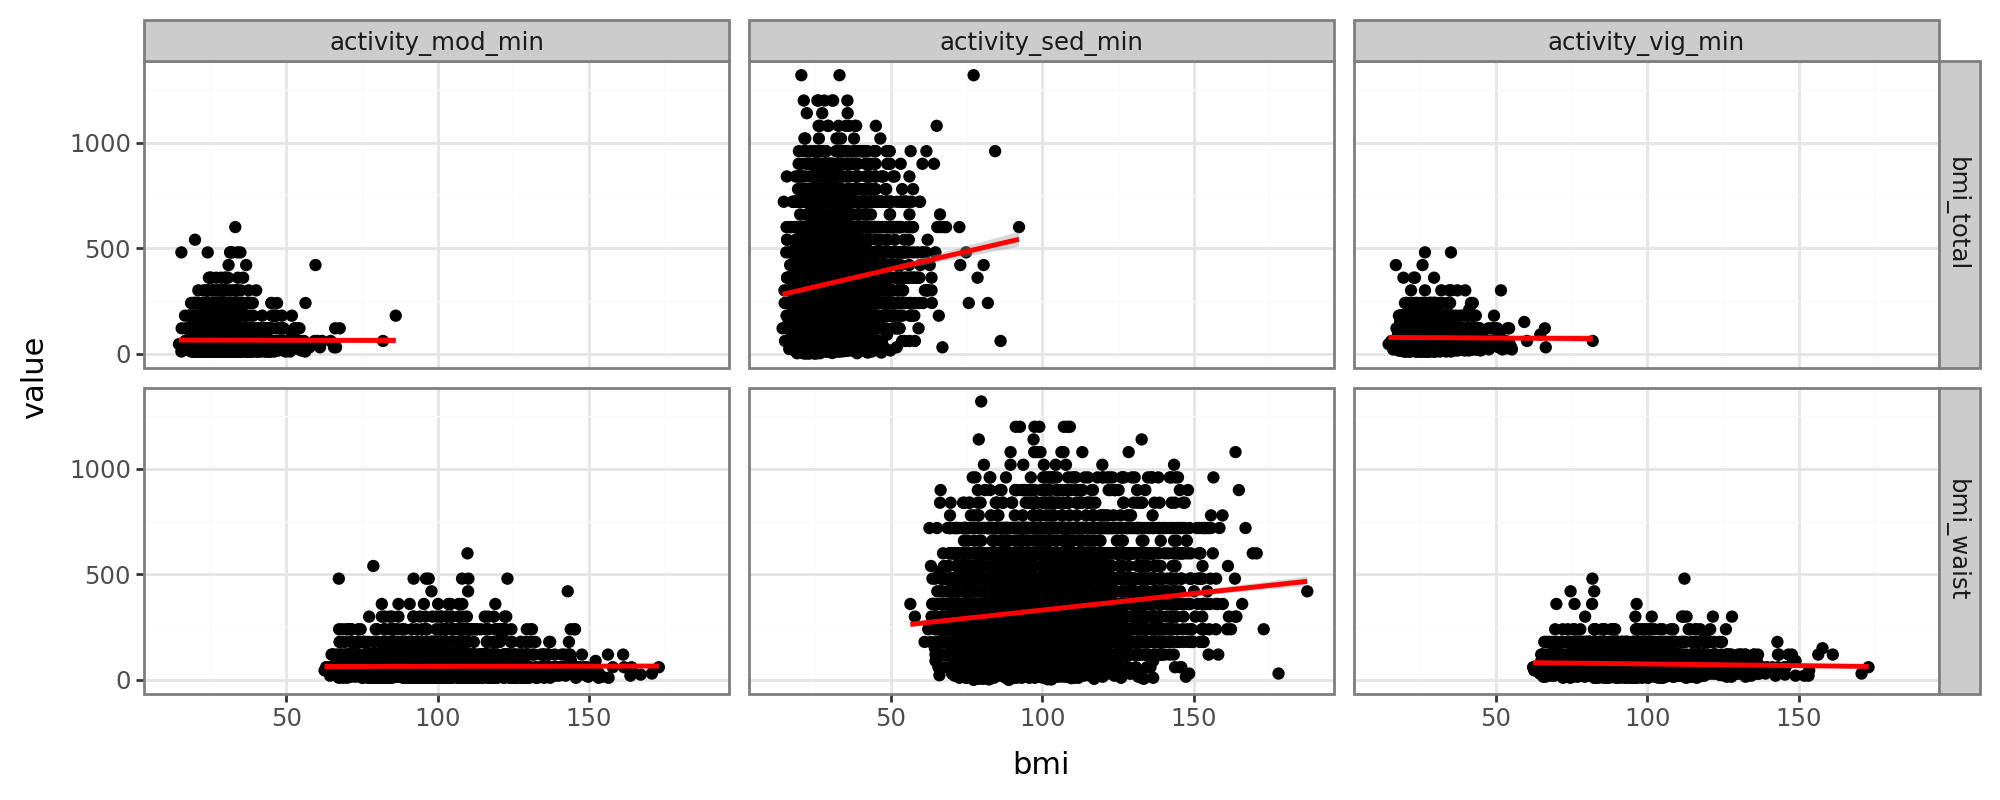

In [13]:
bmi_plot_df = (
    df[
        [
            "bmi_total",
            "bmi_waist",
            "activity_vig_min",
            "activity_mod_min",
            "activity_sed_min",
        ]
    ]
    .melt(id_vars=["bmi_waist", "bmi_total"])
    .melt(id_vars=["variable", "value"], value_name="bmi", var_name="measure")
)
(
    ggplot(
        data=bmi_plot_df,
        mapping=aes(x="bmi", y="value"),
    )
    + geom_point()
    + geom_smooth(color="red")
    + facet_grid("measure~variable", scales="free_y")
    + theme_bw()
    + theme(figure_size=(10, 4))
)

In [14]:
# Below section of EDA done with the cleaned dataset, prepared_data.csv
prepdf = pd.read_csv('../data/prepared_data.csv')

/Users/rachelhimmel/.pyenv/versions/3.9.12/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


Text(0.5, 0, 'Caffeine (Any Source - log(mg))')

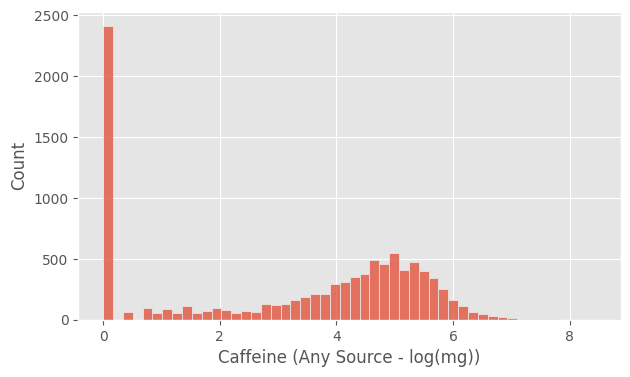

In [18]:
fig = plt.figure(figsize=(7,4))
g = sb.histplot(data = prepdf, x = 'passthrough__any_caffeine_log', bins = 50)
g.set_xlabel("Caffeine (Any Source - log(mg))")

Text(0.5, 0, 'Questionnaire - Kidney Related Variables')

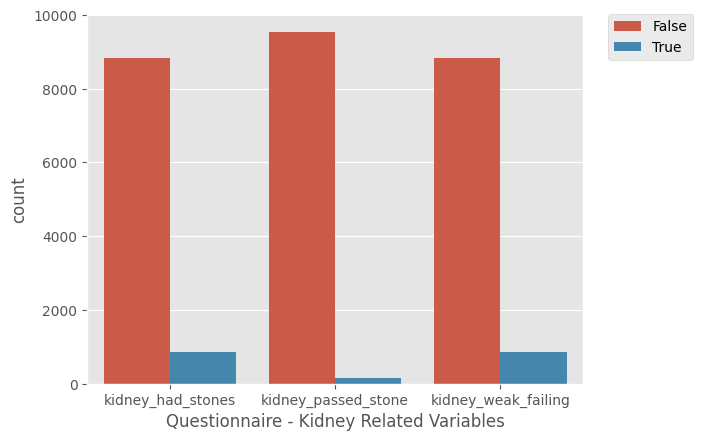

In [19]:
kc_df = prepdf[['kidney_had_stones', 'kidney_passed_stone', 'kidney_weak_failing']]
kc_df = kc_df.melt(ignore_index=False).reset_index()
kc_df['value'] = kc_df['value'].astype(str)
sb.countplot(data = kc_df, x = 'variable', hue = 'value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Questionnaire - Kidney Related Variables')

<Axes: xlabel='kidney_had_stones', ylabel='passthrough__any_caffeine'>

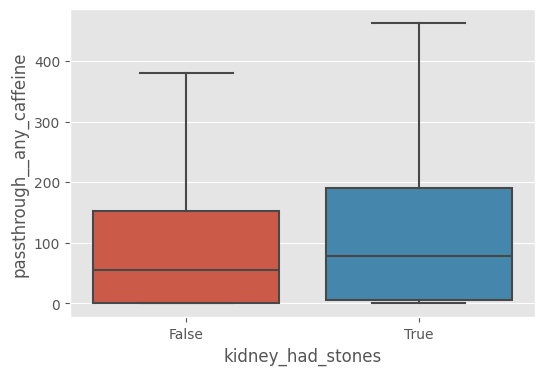

In [21]:
plt.figure(figsize=(6,4))
sb.boxplot(data = prepdf, x = 'kidney_had_stones', y = 'passthrough__any_caffeine', showfliers = False)

/Users/rachelhimmel/.pyenv/versions/3.9.12/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/Users/rachelhimmel/.pyenv/versions/3.9.12/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


Text(0, 0.5, 'Caffeine Consumption – log(mg)')

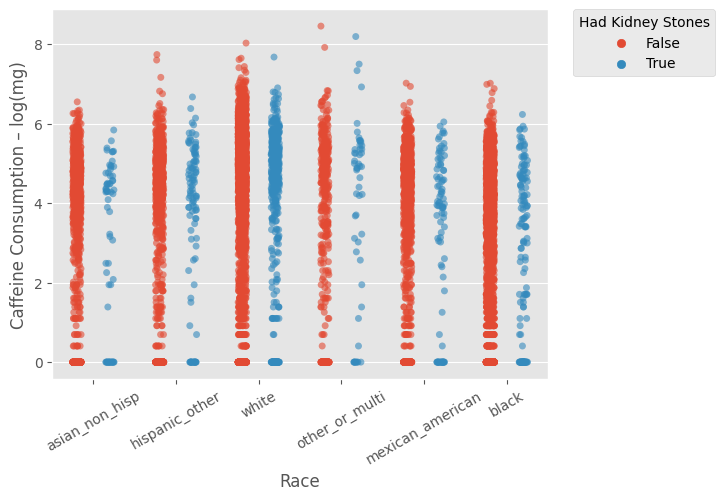

In [22]:
# more white people in the sample, and white people seem to consume more caffeine on avg
temp1 = prepdf.copy()
temp1['demo_race'] = temp1['demo_race'].replace(to_replace = [1.0, 2.0, 3.0, 4.0, 6.0, 7.0], 
                                                value=["mexican_american", "hispanic_other", "white", "black", "asian_non_hisp", "other_or_multi"])
g = sb.stripplot(data = temp1, x="demo_race", y = 'passthrough__any_caffeine_log', hue="kidney_had_stones", dodge=True, alpha = 0.6)
plt.legend(title = 'Had Kidney Stones', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=30)
plt.xlabel('Race')
plt.ylabel("Caffeine Consumption – log(mg)")

In [23]:
prepdf.groupby('demo_race')['kidney_had_stones'].sum()

demo_race
1.00     89
2.00    102
3.00    413
4.00    144
6.00     65
7.00     53
Name: kidney_had_stones, dtype: int64

In [24]:
temp = prepdf[prepdf['occ_work_shift'].isin([1.0, 2.0, 3.0, 5.0])]
temp_avgs = temp.groupby('occ_work_shift')['passthrough__any_caffeine_log'].mean()
temp_avgs

occ_work_shift
1.00   3.45
2.00   3.07
3.00   3.30
5.00   3.41
Name: passthrough__any_caffeine_log, dtype: float64

Text(0.5, 1.0, 'Variable Schedule')

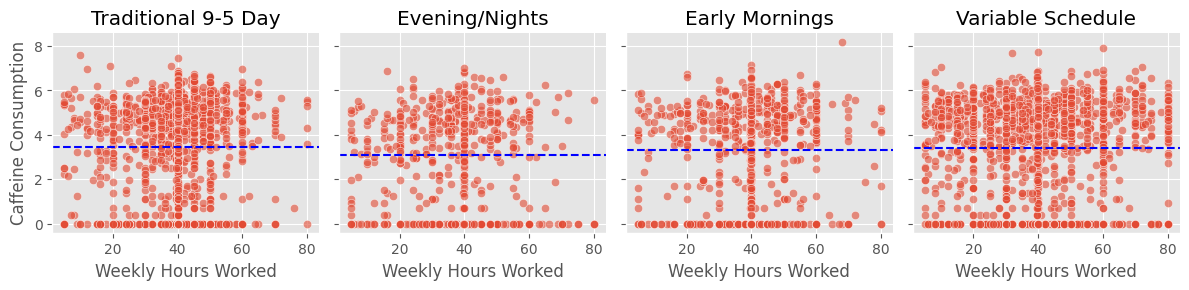

In [25]:
g = sb.FacetGrid(temp, col="occ_work_shift")
g.map(sb.scatterplot, 'static_impute__occ_hours_worked', 'passthrough__any_caffeine_log', alpha=.6)
g.set_xlabels(label = 'Weekly Hours Worked')
g.set_ylabels(label = 'Caffeine Consumption')
a1, a2, a3, a4 = g.axes[0]
a1.axhline(temp_avgs[1.0], ls='--', color = 'blue')
a2.axhline(temp_avgs[2.0], ls='--', color = 'blue')
a3.axhline(temp_avgs[3.0], ls='--', color = 'blue')
a4.axhline(temp_avgs[5.0], ls='--', color = 'blue')
a1.set_title('Traditional 9-5 Day')
a2.set_title('Evening/Nights')
a3.set_title('Early Mornings')
a4.set_title('Variable Schedule')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

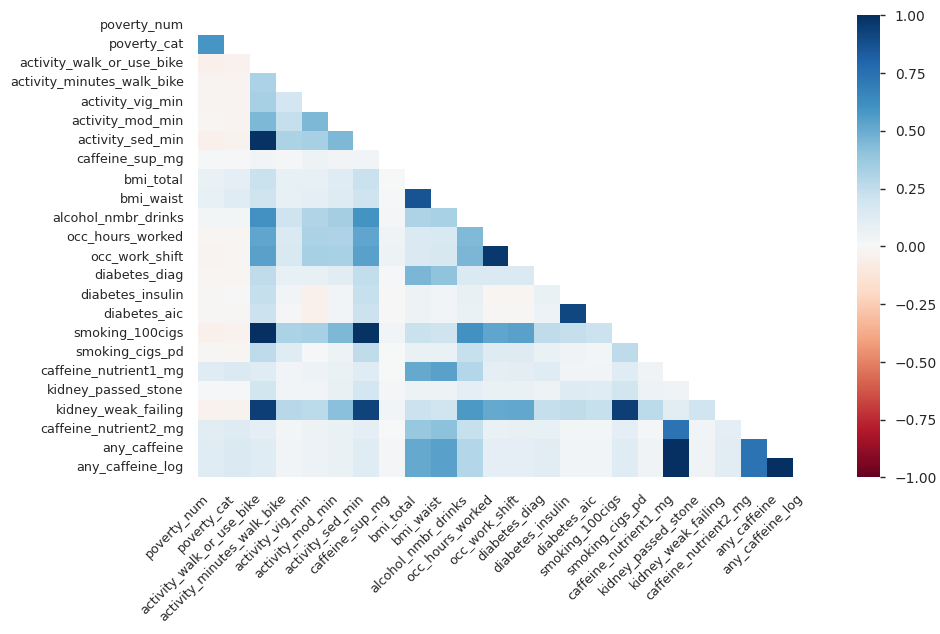

In [26]:
#using profilereport package in python for easy initial look at the data, correlation plot
profile = ProfileReport(df, title="NHANES Data Profile", sort = "ascending", interactions=None, samples=None, dark_mode=True)
profile